In [1]:
import os
import sys
threads_num = 2
os.environ["MKL_NUM_THREADS"] = f"{threads_num}" 
os.environ["NUMEXPR_NUM_THREADS"] = f"{threads_num}"
os.environ["OMP_NUM_THREADS"] = f"{threads_num}"
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import scipy
import numpy as np
import pandas as pd
import genmodel

from utils import colors, sample_type_to_color, sample_type_to_label, export_legend, transform_model, merge_vdj_alleles, full_js_distance, draw_distances, get_distance_stats_test, draw_pvalues

sns.set_style("ticks")

In [2]:
DATA_DIR = "../data/dewitt_plos_one/"
SYNTHETIC_DATA_DIR = "../data/human_synthetic_replicates/"
TEST_DATA_DIR = "../data/dewitt_plos_one_test/"
FIGURES_DIR = "../figures/figure_2/"

In [3]:
sample_types = ["synthetic", "data", "biological", "unrelated"]
sample_sizes = [1000, 3000, 10000, 30000]

# start

In [4]:
def get_distance_stats(n_sequences, exclude):
    run = 1
    main_models = []
    replicate_models = []
    synthetic_replicate_models = []
    n_pairs = 4
    for individual in ["D1-na", "D1-nb", "D2-n", "D3-n"]:
        prefix = os.path.join(DATA_DIR, f"{individual}_{n_sequences}_run/main_inference/final")
        model = genmodel.GenModel(model_parms_file=prefix + "_parms.txt",
                                  marginals_file=prefix + "_marginals.txt")
        main_models.append(model)
        prefix = os.path.join(DATA_DIR, f"{individual}_data_replicate_{n_sequences}_run/main_inference/final")
        model = genmodel.GenModel(model_parms_file=prefix + "_parms.txt",
                                  marginals_file=prefix + "_marginals.txt")
        replicate_models.append(model)
    n_synthetic_samples = 30
    
    for synthetic_id in range(n_synthetic_samples):
        prefix = os.path.join(SYNTHETIC_DATA_DIR, f"synthetic_replicate_{synthetic_id}_{n_sequences}_run/main_inference/final")
        model = genmodel.GenModel(model_parms_file=prefix + "_parms.txt",
                                      marginals_file=prefix + "_marginals.txt")
        synthetic_replicate_models.append(model)
            
    n_samples = 4
    if len(main_models) != n_samples or len(replicate_models) != n_samples:
        raise Exception
    transformed_main_models = [merge_vdj_alleles(m) for m in main_models]
    transformed_replicate_models = [merge_vdj_alleles(m) for m in replicate_models]
    transformed_synthetic_replicate_models = [merge_vdj_alleles(m) for m in synthetic_replicate_models]

    data_replicate_distances = [full_js_distance(transformed_main_models[i],
                                                                     transformed_replicate_models[i],
                                                                     exclude=exclude) \
                                   for i in range(n_samples)]
    biological_replicate_distances = [full_js_distance(transformed_main_models[0],
                                                       transformed_main_models[1],
                                                       exclude=exclude)] + \
                                     [full_js_distance(transformed_replicate_models[0],
                                                       transformed_replicate_models[1],
                                                       exclude=exclude)] + \
                                     [full_js_distance(transformed_main_models[0],
                                                       transformed_replicate_models[1],
                                                       exclude=exclude)] + \
                                     [full_js_distance(transformed_replicate_models[0],
                                                       transformed_main_models[1],
                                                       exclude=exclude)]
    unrelated_distances = [full_js_distance(transformed_main_models[i],
                                                                transformed_main_models[k],
                                                                     exclude=exclude) \
                                   for i in range(n_samples) for k in range(i + 1, n_samples) \
                                   if not (i == 0 and k == 1)] +\
                          [full_js_distance(transformed_replicate_models[i],
                                                                transformed_replicate_models[k],
                                                                     exclude=exclude) \
                                   for i in range(n_samples) for k in range(i + 1, n_samples) \
                                   if not (i == 0 and k == 1)]
    synthetic_distances = [full_js_distance(transformed_synthetic_replicate_models[i],
                                            transformed_synthetic_replicate_models[k],
                                            exclude=exclude) \
                           for i in range(n_synthetic_samples) for k in range(i + 1, n_synthetic_samples)]
    
    return {"synthetic": synthetic_distances,
            "data": data_replicate_distances,
            "biological": biological_replicate_distances,
            "unrelated": unrelated_distances}


In [5]:
exclude = []
statistics = {}
for n_sequences in sample_sizes:
    for sample_type in sample_sizes:
        statistics[n_sequences] = get_distance_stats(n_sequences, exclude)

In [6]:
ylim_explicit = (0, 1.5)
ylim_normalized = (0.5, 6.1)

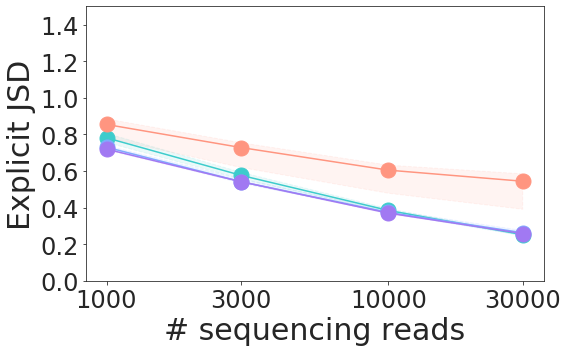

In [7]:
draw_distances(statistics, sample_types=sample_types, normalize=False, ylim=ylim_explicit, output_filename=os.path.join(FIGURES_DIR, "dewitt_plos_one_explicit.png"))

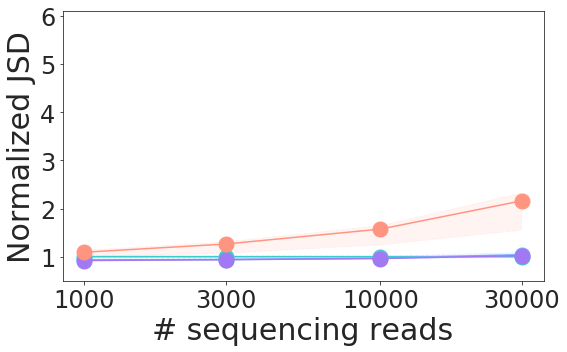

In [8]:
draw_distances(statistics, sample_types=sample_types, normalize=True, ylim=ylim_normalized, output_filename=os.path.join(FIGURES_DIR, "dewitt_plos_one_normalized.png"))

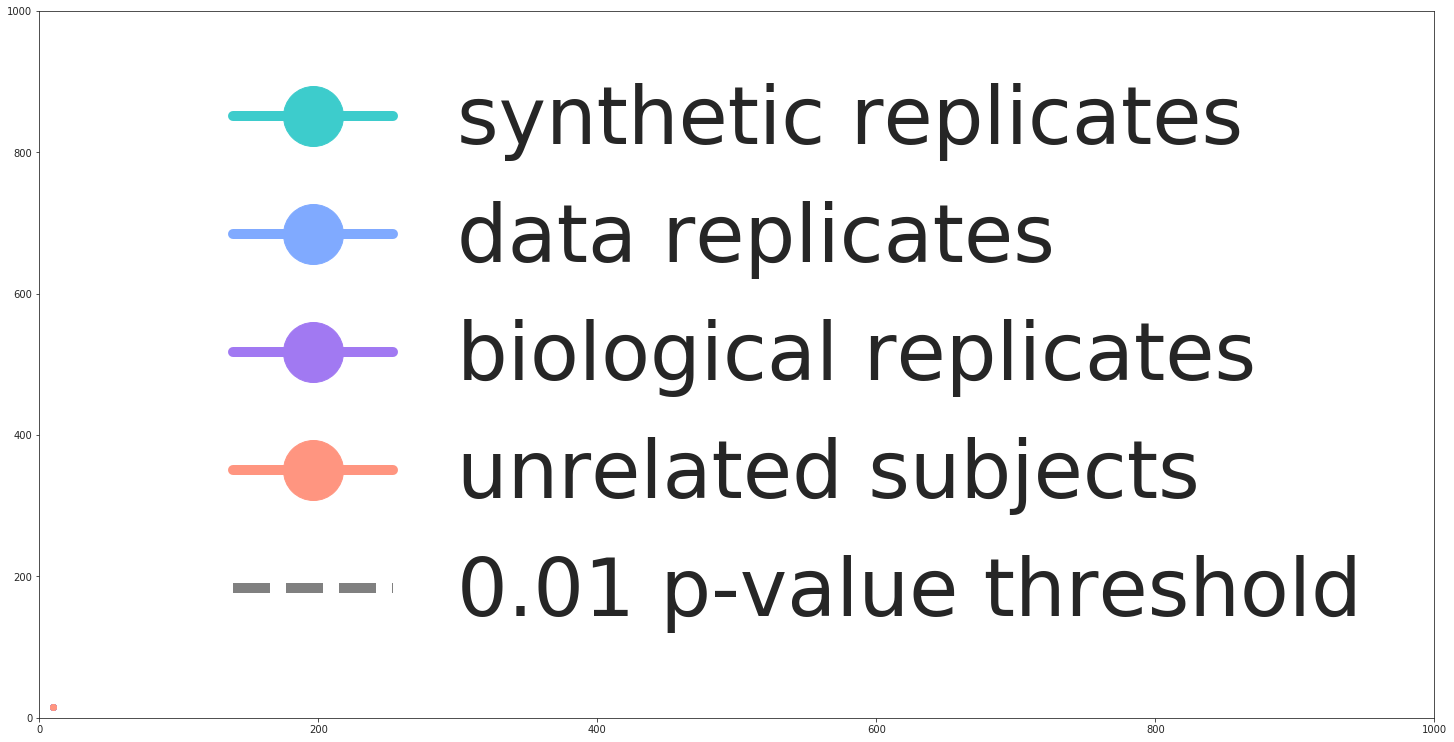

In [9]:
fig = plt.figure(figsize=(25, 13))
fontsize = 25
x = [10, 10]
y = [15, 15]
plt.xlim((0, 1e3))
plt.ylim((0, 1e3))

for sample_type in statistics[1000].keys():
    plt.plot(x, y, color=sample_type_to_color[sample_type], label=sample_type_to_label[sample_type], marker='o')
plt.plot(x, y, color="grey", linestyle="--", label="0.01 p-value threshold")

sc_coef = 4
leg = plt.legend(fontsize=fontsize * 0.8 * sc_coef, markerscale=2.5 * sc_coef)
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.5 * sc_coef)
export_legend(leg, filename=os.path.join(FIGURES_DIR, "legend_dewitt_plot_one.png"))
plt.show()

In [10]:
test_distances = {}
names = ["data", "biological", "unrelated"]
for n_sequences in sample_sizes:
    test_distances[n_sequences] = {}
    main_distances, other_distances = get_distance_stats_test(TEST_DATA_DIR, n_sequences, names)
    test_distances[n_sequences]["self"] = main_distances
    for name in names:
        test_distances[n_sequences][name] = other_distances[name]
    


In [11]:
pvalues = {}
n_tests = len(sample_sizes) * len(names)
for n_sequences in sample_sizes:
    pvalues[n_sequences] = {}
    for name in names:
        pvalues[n_sequences][name] = scipy.stats.ttest_ind(test_distances[n_sequences]["self"],
                                                           test_distances[n_sequences][name],
                                                           equal_var=False,
                                                           alternative="less").pvalue * n_tests

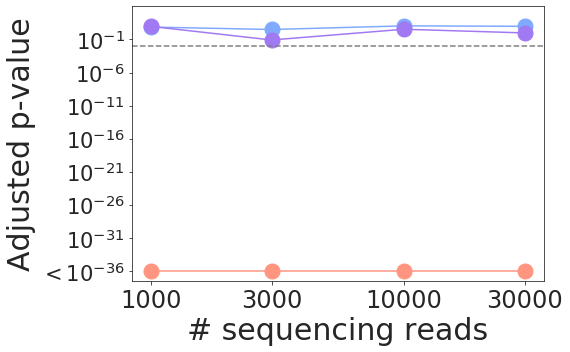

In [12]:
draw_pvalues(pvalues, names, output_filename=os.path.join(FIGURES_DIR, "dewitt_plos_one_pvalue.png"))

# no v

In [13]:
exclude = ["v_delv", "v_d_j"]
statistics_no_v = {}
for n_sequences in sample_sizes:
    for sample_type in sample_sizes:
        statistics_no_v[n_sequences] = get_distance_stats(n_sequences, exclude)

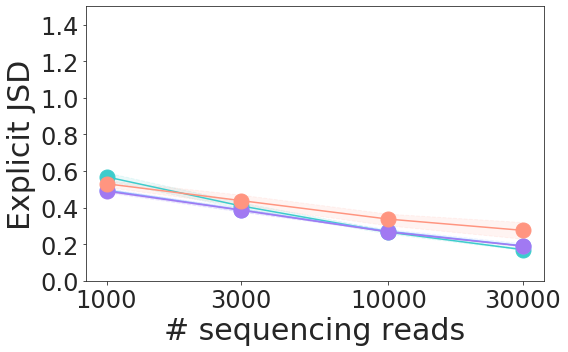

In [14]:
draw_distances(statistics_no_v, sample_types=sample_types, normalize=False, ylim=ylim_explicit, output_filename=os.path.join(FIGURES_DIR, "dewitt_plos_one_explicit_no_v.png"))

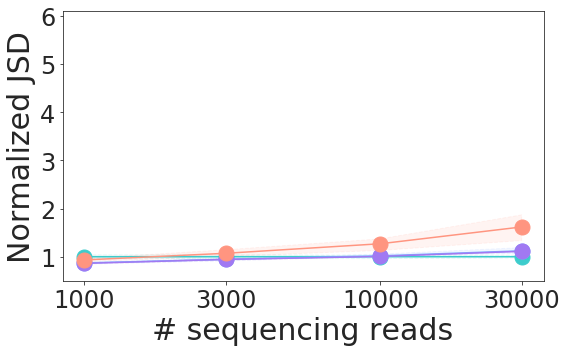

In [15]:
draw_distances(statistics_no_v, sample_types=sample_types, normalize=True, ylim=ylim_normalized, output_filename=os.path.join(FIGURES_DIR, "dewitt_plos_one_normalized_no_v.png"))

# only v

In [16]:
keys = {'v_delv', 'd_deld', 'dj_ins', 'j_delj', 'v_d_j', 'vd_ins'}

In [17]:
exclude = keys - {"v_delv", "v_d_j"}
statistics_only_v = {}
for n_sequences in sample_sizes:
    for sample_type in sample_sizes:
        statistics_only_v[n_sequences] = get_distance_stats(n_sequences, exclude)

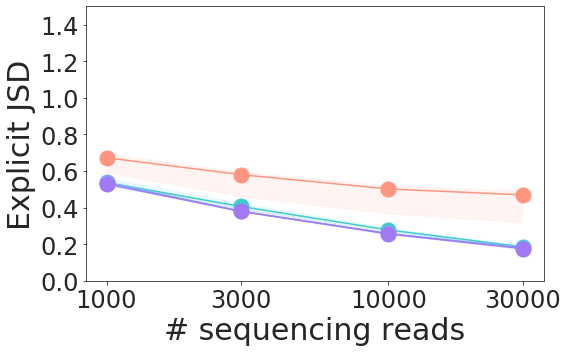

In [18]:
draw_distances(statistics_only_v, sample_types=sample_types, normalize=False, ylim=ylim_explicit, output_filename=os.path.join(FIGURES_DIR, "dewitt_plos_one_explicit_only_v.png"))

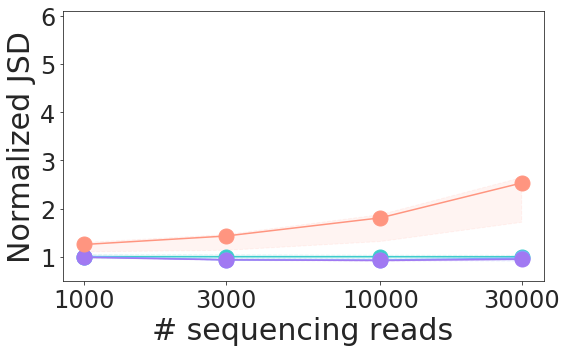

In [19]:
draw_distances(statistics_only_v, sample_types=sample_types, normalize=True, ylim=ylim_normalized, output_filename=os.path.join(FIGURES_DIR, "dewitt_plos_one_normalized_only_v.png"))